本教程将会教会你如何从kaggle里面下载数据、如何预处理数据、如何训练模、最后生成训练曲线图和confusion matrix。我强烈建议使用kaggle或者google colab来进行训练，因为这样可以避免由于环境不同而带来的错误。

# 数据准备

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import applications
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Sequential
import numpy as np
from tensorflow.keras.models import load_model
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras import optimizers
import pandas as pd
import cv2

In [1]:
import torch
placeholder = torch.Tensor([1000, 1000, 1000]).cuda()  # 大约占用 1.1G 显存

数据集需要从kaggle中下载，如果你使用kaggle进行接下来的训练工作，可以跳过这里，如果你使用google colab来进行训练，需要通过kaggle command下载对应的数据集，请运行接下来的代码，当然你需要有一个kaggle账号，而且生成了API Token.把token放在colab的/content目录下，运行以下代码进行下载。
## 上传kaggle api token

In [4]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## 从kaggle下载数据集

In [8]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri --unzip --force

 81% 70.0M/86.8M [00:00<00:00, 212MB/s]
100% 86.8M/86.8M [00:00<00:00, 220MB/s]


## 文件夹合并
现在，/content文件夹下会出现两个新的Folder,分别是Testing和Training,里面又包含四个文件夹对应着四个分类。接下来我们想要把两个文件夹合成为一个，这样便于之后导入图片的处理工作。这个操作涉及大量图片复制，所以需要一定时间，我用colab大概需要半分钟左右的时间。

In [26]:
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
target_dir = 'tumor2'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
k = 0
for label in labels:
  if not os.path.exists(f'{target_dir}/{label}'):
    os.mkdir(f'{target_dir}/{label}')
  folderPath = os.path.join('/content/Training',label)
  for j in os.listdir(folderPath):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    cv2.imwrite(f'{target_dir}/{label}/{k}.jpg',img)
    k += 1
  folderPath = os.path.join('/content/Testing',label)
  for j in os.listdir(folderPath):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    cv2.imwrite(f'{target_dir}/{label}/{k}.jpg',img)
    k += 1

现在，你可以看到在/content又多出一个文件夹，名为'tumor2',这个文件夹里面又有四个文件夹，对应四个分类，证明我们的复制工作成功了。

## 数据可视化
我们来看看这四个类别的图片分别都是怎样的吧。

In [ ]:
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
k = 0
x = []
y = []
for label in labels:
  folderPath = os.path.join('/content/Testing',label)
  for j in os.listdir(folderPath):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x.append(img)
    y.append(label)
    break
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='model performance',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
model = load_model('efficient-net-b0.h5')
predictions = model.predict(x)
predictions = np.argmax(predictions, axis=1)
for i in range(4):
  ax[i].imshow(x[i])
  ax[i].set_title(y[i])
  ax[i].axis('off')

# 数据预处理
接下来我们开始做一些预处理工作，首先确定以下参数.

In [15]:
# some parameter
data_dir = './tumor2'
image_size = 150
batch_size = 64
seed = 123456
validation_split = 0.2
epochs = 60

image_dataset_from_directory可以方便的根据文件夹结构载入图片以及其对应的label，这里train_ds就是用于模型训练的datasets，所以subset为training,validation_split的作用是从各个类别的图片中分出百分之八十作为训练集，而百分二十作为测试集。

In [27]:
# prepare data
train_ds = image_dataset_from_directory(
    data_dir,
    seed=seed,
    validation_split=validation_split,
    subset="training",
    image_size=(image_size, image_size),
    batch_size=batch_size)

val_ds = image_dataset_from_directory(
    data_dir,
    seed=seed,
    validation_split=validation_split,
    subset="validation",
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 3264 files belonging to 4 classes.
Using 2612 files for training.
Found 3264 files belonging to 4 classes.
Using 652 files for validation.


In [17]:
labels = train_ds.class_names
print(f'class name {labels}')

class name ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


# 模型训练
接下来是模型训练环节，我们将会训练多种模型，包括VGG,Resnet,Efficient-Net三类模型。


## 热身
我们先来热热身，用一个较为简单的模型进行训练，以测试训练是否可以正常进行。注意这里还使用了数据增强的方法，这样可以提高模型的精度。

In [28]:
model_name = 'basic-cnn'
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip(
      "horizontal", input_shape=(image_size, image_size, 3)),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1)
])
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(
      1./255, input_shape=(image_size, image_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4, activation='softmax')
])

这里我们使用Adam优化器，loss使用Crossentropy,metrics是准确度，训练过程会生成Tensorboard日志文件，自动保存最好的模型，还有指定了learning rate下降的策略

In [29]:
model.compile(optimizer=optimizers.Adam(0.001), loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint(
    f"{model_name}.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.001,
                              mode='auto', verbose=1)

In [30]:
# start training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)

Epoch 1/60
41/41 [==============================] - 4s 82ms/step - loss: 1.2229 - accuracy: 0.4483 - val_loss: 1.1122 - val_accuracy: 0.4770

Epoch 00001: val_accuracy improved from -inf to 0.47699, saving model to basic-cnn.h5
Epoch 2/60
41/41 [==============================] - 2s 54ms/step - loss: 0.9991 - accuracy: 0.5666 - val_loss: 0.9905 - val_accuracy: 0.5798

Epoch 00002: val_accuracy improved from 0.47699 to 0.57975, saving model to basic-cnn.h5
Epoch 3/60
41/41 [==============================] - 2s 52ms/step - loss: 0.8941 - accuracy: 0.6240 - val_loss: 0.8384 - val_accuracy: 0.6656

Epoch 00003: val_accuracy improved from 0.57975 to 0.66564, saving model to basic-cnn.h5
Epoch 4/60
41/41 [==============================] - 2s 52ms/step - loss: 0.7847 - accuracy: 0.6811 - val_loss: 0.7171 - val_accuracy: 0.7009

Epoch 00004: val_accuracy improved from 0.66564 to 0.70092, saving model to basic-cnn.h5
Epoch 5/60
41/41 [==============================] - 2s 53ms/step - loss: 0.7675

这里画出准确度和loss的变化曲线

In [31]:
def show_acc(acc, val_acc):
  epochs_range = range(len(acc))

  # plt.figure(figsize=(8, 8))
  plt.ylim(0.7, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.show()


def show_loss(loss, val_loss):
  epochs_range = range(len(loss))
  plt.ylim(0, 1)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

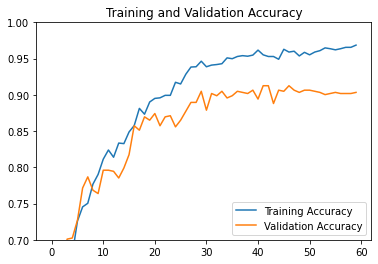

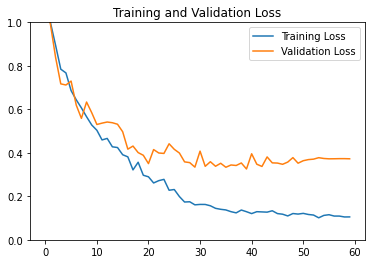

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
show_acc(acc, val_acc)


loss = history.history['loss']
val_loss = history.history['val_loss']
show_loss(loss, val_loss)

这里可以保存训练曲线到一个csv文件方便之后要对各个模型性能进行分析。

In [37]:
def save_learning_curve(history, hist_csv_file):
  hist_df = pd.DataFrame(history.history) 
  with open(hist_csv_file, mode='w') as f:
      hist_df.to_csv(f)

In [38]:
save_learning_curve(history, 'basic-cnn-history.csv')

到这里，如果你看到模型可以达到大概90%的准确度，那么证明前面的工作都是没有问题的。这样我们就可以进行复杂模型的训练了。

注意之后复杂模型的训练都需要较长的训练时间，请确保开启了GPU，我用google colab pro进行训练，平均一个模型的训练时长是15分钟。同时需要注意训练结果并不是一成不变的，有可能你的训练结果会很糟糕，没关系这是正常的，你可以尝试多次来直到模型达到你的预期效果。

## efficient-net-b0 模型训练


In [73]:
# Here you can choose different kind of efficient-net, from b0 to b7, 
# but remember that the higher the number the larger the model is
model_name = 'efficient-net-b0' # model_name could be 'efficient-net-b0~b7'


i = layers.Input([image_size, image_size, 3], dtype=tf.uint8)
x = tf.cast(i, tf.float32)
# if you change the model name, please also change this function to corresponding function
core = applications.EfficientNetB0(include_top=False,weights='imagenet')
x = core(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/60
41/41 [==============================] - 21s 312ms/step - loss: 0.4992 - accuracy: 0.8090 - val_loss: 1.0135 - val_accuracy: 0.6564

Epoch 00001: val_accuracy improved from -inf to 0.65644, saving model to efficient-net-b0.h5
Epoch 2/60
41/41 [==============================] - 10s 234ms/step - loss: 0.1351 - accuracy: 0.9564 - val_loss: 0.4221 - val_accuracy: 0.8804

Epoch 00002: val_accuracy improved from 0.65644 to 0.88037, saving model to efficient-net-b0.h5
Epoch 3/60
41/41 [==============================] - 10s 235ms/step - loss: 0.0729 - accuracy: 0.9747 - val_loss: 0.3424 - val_accuracy: 0.9049

Epoch 00003: val_accuracy improved from 0.88037 to 0.90491, saving model to efficient-net-b0.h5
Epoch 4/60
41/41 [==============================] - 10s 236ms/step - loss: 0.0745 - accuracy: 0.9782 - val_loss: 0.3564 - val_accuracy: 0.9187

Epoch 00004: val_accuracy improved from 0.90491 to 0.91871, saving model to efficient-net-b0.h5
Epoch 5/60
41/41 [=========================

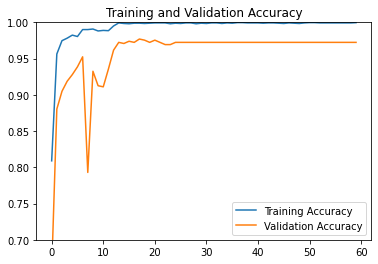

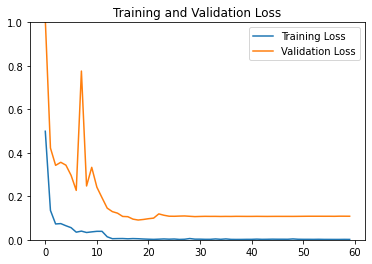

In [39]:
model.compile(optimizer=optimizers.Adam(0.0003), loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint(
    f"{model_name}.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.001,
                              mode='auto', verbose=1)
# start training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
show_acc(acc, val_acc)


loss = history.history['loss']
val_loss = history.history['val_loss']
show_loss(loss, val_loss)

save_learning_curve(history, 'efficient-net-b0-history.csv')

## VGG16 模型训练
VGG16需要特别注意，因为如果你像其他两类网络那样使用了预训练权重作为初始值，将会出现网络无法训练的问题，你将会看到准确率永远是0.28左右而不会提升，出现这个问题的原因可能是Imagenet的图片与大脑MRI图片存在较大差别，VGG的拟合能力又不如其他两种网络，所以导致它无法正常学习。解决方案也比较简单，就是把weights设置为None，这样就不会用Imagenet的预训练权重进行网络初始化了。

In [67]:
model_name = 'vgg16'
# add the data augmentation layer to reduce val loss
# vgg 如果使用预训练模型作为初始值会导致无法学习，
# 训练efficient-net用预训练模型可以学习，但是一开始loss会向上飙然后再下降
# 我认为是imagenet和MRI的图片存在很大区别，而effiient-net能力足够强
# 即使用预训练模型，也可以得到正常的结果

# vgg网络如果不加图像增强层，最后val_loss会比较大，大概0.56的样子，
# 如果加上图像增强层，val_loss回归正常水平
data_augmentation = Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(image_size, image_size, 3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

i = layers.Input([image_size, image_size, 3], dtype=tf.uint8)
x = data_augmentation(i)
x = tf.cast(x, tf.float32)
x = applications.vgg16.preprocess_input(x)
core = applications.vgg16.VGG16(include_top=False, weights=None)
x = core(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

Epoch 1/60
41/41 [==============================] - 51s 281ms/step - loss: 1.4176 - accuracy: 0.3139 - val_loss: 1.2329 - val_accuracy: 0.3788

Epoch 00001: val_accuracy improved from -inf to 0.37883, saving model to vgg16.h5
Epoch 2/60
41/41 [==============================] - 11s 255ms/step - loss: 1.2365 - accuracy: 0.4158 - val_loss: 1.3640 - val_accuracy: 0.3773

Epoch 00002: val_accuracy did not improve from 0.37883
Epoch 3/60
41/41 [==============================] - 11s 262ms/step - loss: 1.1370 - accuracy: 0.5069 - val_loss: 1.0345 - val_accuracy: 0.5920

Epoch 00003: val_accuracy improved from 0.37883 to 0.59202, saving model to vgg16.h5
Epoch 4/60
41/41 [==============================] - 10s 251ms/step - loss: 1.0491 - accuracy: 0.5636 - val_loss: 1.0037 - val_accuracy: 0.5951

Epoch 00004: val_accuracy improved from 0.59202 to 0.59509, saving model to vgg16.h5
Epoch 5/60
41/41 [==============================] - 10s 252ms/step - loss: 0.9993 - accuracy: 0.5842 - val_loss: 0.87

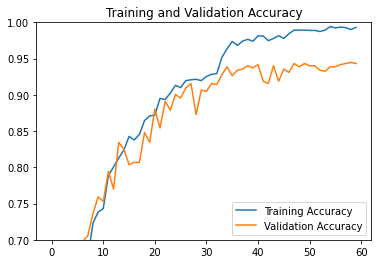

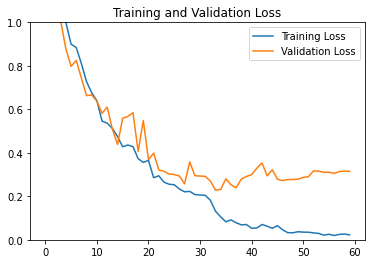

In [68]:
model.compile(optimizer=optimizers.Adam(0.0003), loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint(
    f"{model_name}.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.001,
                              mode='auto', verbose=1)
# start training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
show_acc(acc, val_acc)


loss = history.history['loss']
val_loss = history.history['val_loss']
show_loss(loss, val_loss)

save_learning_curve(history, 'vgg16-history.csv')

## Resnet50 模型训练

In [78]:
model_name = 'resnet50'
i = layers.Input([image_size, image_size, 3], dtype=tf.uint8)
x = tf.cast(i, tf.float32)
x = applications.resnet.preprocess_input(x)
core = applications.resnet.ResNet50(include_top=False,weights='imagenet')
x = core(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/60
41/41 [==============================] - 17s 297ms/step - loss: 2.6445 - accuracy: 0.7312 - val_loss: 1.4863 - val_accuracy: 0.7715

Epoch 00001: val_accuracy improved from -inf to 0.77147, saving model to resnet50.h5
Epoch 2/60
41/41 [==============================] - 10s 230ms/step - loss: 0.1650 - accuracy: 0.9364 - val_loss: 0.4561 - val_accuracy: 0.8957

Epoch 00002: val_accuracy improved from 0.77147 to 0.89571, saving model to resnet50.h5
Epoch 3/60
41/41 [==============================] - 10s 228ms/step - loss: 0.0462 - accuracy: 0.9881 - val_loss: 0.2528 - val_accuracy: 0.9187

Epoch 00003: val_accuracy improved from 0.89571 to 0.91871, saving model to resnet50.h5
Epoch 4/60
41/41 [==============================] - 10s 229ms/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.2760 - val_accuracy: 0.9279

Epoch 00004: val_accuracy improved from 0.91871 to 0.92791, saving model to resnet50.h5
Epoch 5/60
41/41 [==============================] - 10s 230ms/step - loss: 

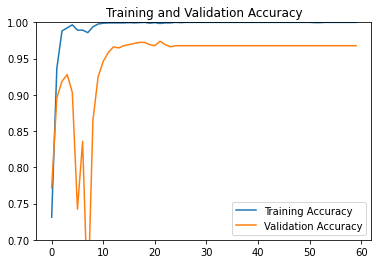

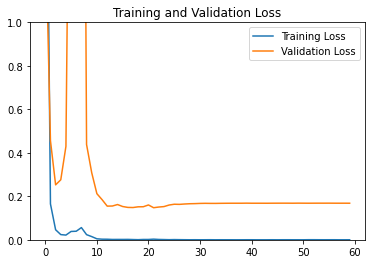

In [79]:
model.compile(optimizer=optimizers.Adam(0.0003), loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint(
    f"{model_name}.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.001,
                              mode='auto', verbose=1)
# start training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
show_acc(acc, val_acc)


loss = history.history['loss']
val_loss = history.history['val_loss']
show_loss(loss, val_loss)

save_learning_curve(history, 'resnet50-history.csv')

# 训练数据分析与模型测试
## 训练数据分析
这里是一个读取csv进行比较的例子，这里是工作是导入efficient-net-b0,vgg16以及resnet50的训练曲线，然后比较他们loss的收敛情况

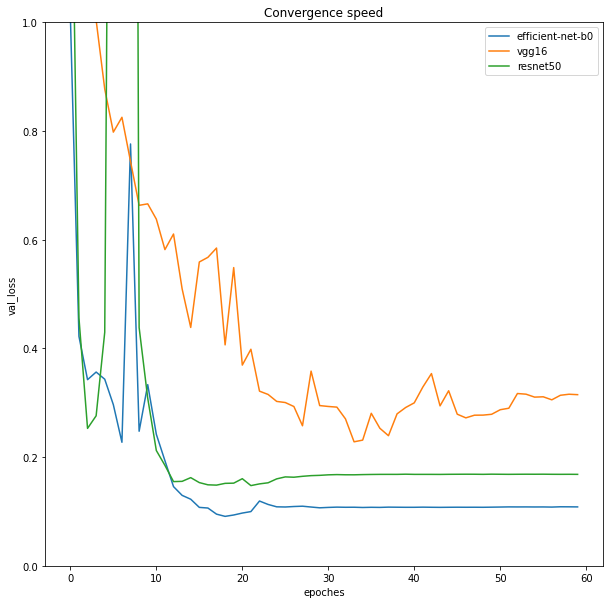

In [80]:
file_names = ['efficient-net-b0-history.csv', 'vgg16-history.csv', 'resnet50-history.csv']
labels = ['efficient-net-b0','vgg16','resnet50']
epochs_range = range(60)

plt.figure(figsize=(10,10))
plt.ylim(0, 1)

for label, name in zip(labels, file_names):
  val_loss = pd.read_csv(name)['val_loss'].values
  plt.plot(epochs_range, val_loss, label=label)
  plt.legend(loc='upper right')
plt.xlabel('epoches')
plt.ylabel('val_loss')
plt.title('Convergence speed')
plt.show()

这个是比较上面提及的三个模型的准确度变化情况

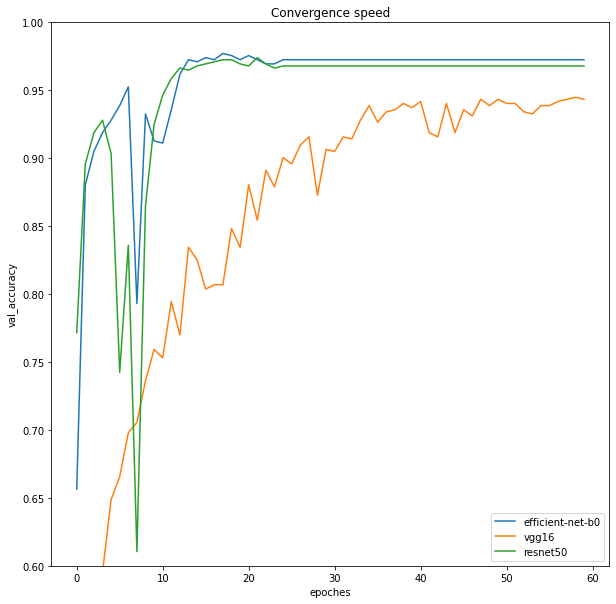

In [81]:
plt.figure(figsize=(10,10))
plt.ylim(0.6, 1)

for label, name in zip(labels, file_names):
  val_loss = pd.read_csv(name)['val_accuracy'].values
  plt.plot(epochs_range, val_loss, label=label)
  plt.legend(loc='lower right')
plt.xlabel('epoches')
plt.ylabel('val_accuracy')
plt.title('Convergence speed')
plt.show()

## 模型测试


In [86]:
model_names = ['efficient-net-b0.h5','vgg16.h5','resnet50.h5']
for name in model_names:
  print(f'loading {name}')
  model = load_model(name)
  model.evaluate(val_ds)
  print('|'+'=='*45+'|')

loading efficient-net-b0.h5
11/11 [==============================] - 2s 44ms/step - loss: 0.0950 - accuracy: 0.9770
|==========================================================================================|
loading vgg16.h5
11/11 [==============================] - 1s 66ms/step - loss: 0.3156 - accuracy: 0.9448
|==========================================================================================|
loading resnet50.h5
11/11 [==============================] - 2s 62ms/step - loss: 0.1475 - accuracy: 0.9739
|==========================================================================================|


## 训练结果可视化
我们只使用训练效果最好的efficient-net，我们先要导入最好的模型。



In [ ]:
model = load_model('efficient-net-b0.h5')
model.summary()

在Testing文件夹中，每个类别我们拿一张图片出来做测试。

In [46]:
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
k = 0
x = []
y = []
for label in labels:
  folderPath = os.path.join('/content/Testing',label)
  for j in os.listdir(folderPath):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x.append(img)
    y.append(label)
    break
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(4, 150, 150, 3)
(4,)


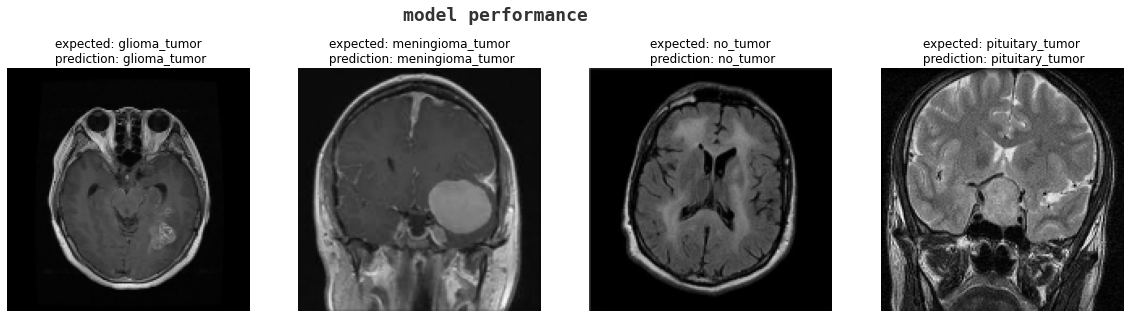

In [49]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='model performance',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
model = load_model('efficient-net-b0.h5')
predictions = model.predict(x)
predictions = np.argmax(predictions, axis=1)
for i in range(4):
  ax[i].imshow(x[i])
  ax[i].set_title(f'expected: {y[i]}\n prediction: {labels[predictions[i]]}')
  ax[i].axis('off')


我们还可以画confusion matrix

In [55]:
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
k = 0
x = []
y = []
for i,label in enumerate(labels):
  folderPath = os.path.join('/content/Testing',label)
  for j in os.listdir(folderPath)[:15]:
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x.append(img)
    y.append(i)
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(60, 150, 150, 3)
(60,)


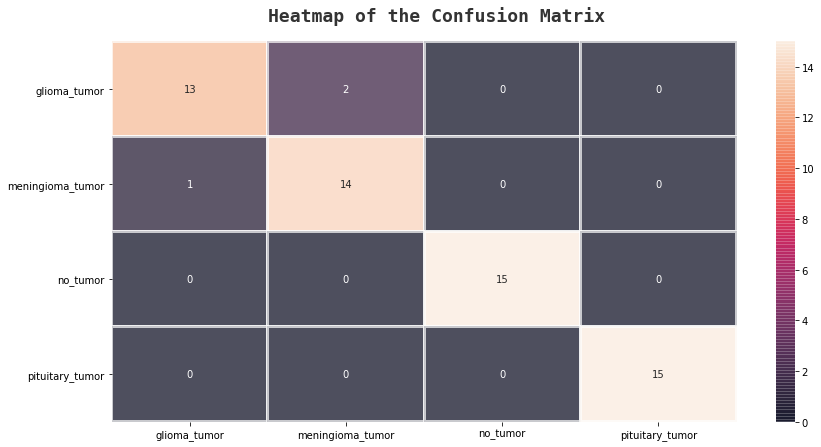

In [58]:
pred = model.predict(x)
pred = np.argmax(pred, axis=1)

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y,pred),ax=ax,xticklabels=labels,
            yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

# 总结
自此，教程就结束了。在本教程中你学会了如何准备从kaggle网站获取大脑MRI图片，如何做图片的预处理，如何训练各种现在常用的model，并测试这些model的性能，最后可视化训练结果。

感谢看完本教程！希望你学到了很多，并非常享受这个学习之旅。